## ERDAP with erddapy example for ITAE Prawler - 2018 M2 (BSITAEPR-2A)

***requires python 3.6*** for passing time information (pandas datetime to timestamp doesn't appear to work in 2.7)

### connecting and basic information

In [1]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

server_url = 'http://krafla.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url)

In [2]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='PRAWLER'))

In [3]:
'We have {} tabledap, {} griddap, and {} wms endpoints.'.format(
    len(set(df['tabledap'].dropna())),
    len(set(df['griddap'].dropna())),
    len(set(df['wms'].dropna()))
)

'We have 4 tabledap, 0 griddap, and 0 wms endpoints.'

In [4]:
prawlers = df['Dataset ID'].values
print(prawlers)

['erddap_4fd3_fb30_b89f' 'erddap_17bsitae_prawler'
 'erddap_17ckitaem2a_prawler' 'erddap_18bsitaepr2a_prawler']


In [5]:
variables = [e.get_var_by_attr(dataset_id=prawler, standard_name=lambda v: v is not None) for prawler in prawlers]
print(variables)

[['Chlorophyll', 'depth', 'latitude', 'time', 'longitude', 'Salinity'], ['Chlorophyll', 'depth', 'latitude', 'time', 'longitude', 'Salinity'], ['Chlorophyll', 'depth', 'latitude', 'time', 'longitude', 'Salinity'], ['Chlorophyll', 'depth', 'latitude', 'time', 'longitude', 'Salinity']]


### retrieving and plotting data

In [20]:
constraints = {
    'time>=': '2015-01-01T00:00:00Z',
    'time<=': '2017-10-10T00:00:00Z',
    'latitude>=': 45,
    'latitude<=': 90,
    'longitude>=': 180,
    'longitude<=': 210
}

variables = [
 'Temperature',
 'Salinity',
 'Chlorophyll',
 'latitude',
 'longitude',
 'depth',
 'time'
]

d = ERDDAP(server=server_url,
           protocol='tabledap',
           response='csv',
           dataset_id='erddap_17ckitaem2a_prawler',
           variables=variables,
           constraints=constraints
          )

In [21]:
d.get_download_url()

'http://krafla.pmel.noaa.gov:8080/erddap/tabledap/erddap_17ckitaem2a_prawler.csv?Temperature,Salinity,Chlorophyll,latitude,longitude,depth,time&time>=1420070400.0&time<=1507593600.0&latitude>=45&latitude<=90&longitude>=180&longitude<=210'

In [22]:
df = d.to_pandas(
    index_col='time',
    parse_dates=True,
    skiprows=(1,)  # units information can be dropped.
).dropna()

df.head()

,Temperature,Salinity,Chlorophyll,latitude,longitude,depth
time,,,,,,
2017-07-29 07:15:00,5.578,31.612,0.237,71.219002,195.742996,6.1
2017-07-29 07:15:00,5.587,31.767,0.305,71.219002,195.742996,6.0
2017-07-29 07:15:00,5.609,31.777,0.316,71.219002,195.742996,5.9
2017-07-29 07:15:00,5.612,31.780,0.237,71.219002,195.742996,6.0
2017-07-29 07:15:00,5.622,31.778,0.271,71.219002,195.742996,5.8


In [23]:
#qc
df['Temperature'][df['Temperature']>20]=np.nan

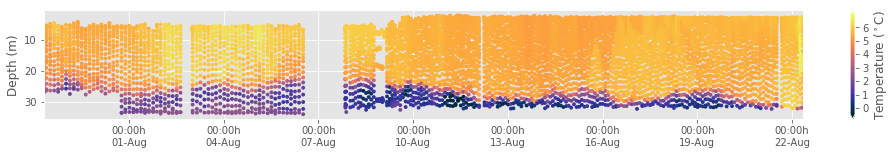

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean

fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['depth'], s=15, c=df['Temperature'], marker='o', edgecolor='none', cmap=cmocean.cm.thermal)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%H:%Mh\n%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_ylabel('Depth (m)');

In [25]:
df['Temperature'].max()

6.891

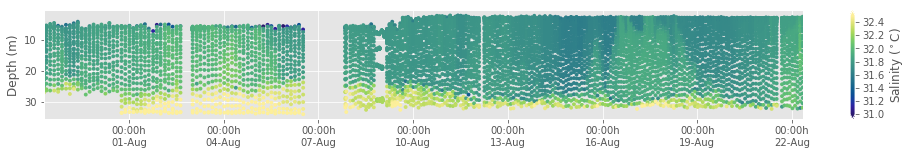

In [26]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['depth'], s=15, c=df['Salinity'], marker='o', edgecolor='none', vmin=31, vmax=32.5, cmap=cmocean.cm.haline)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%H:%Mh\n%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Salinity ($^\circ$C)')
ax.set_ylabel('Depth (m)');

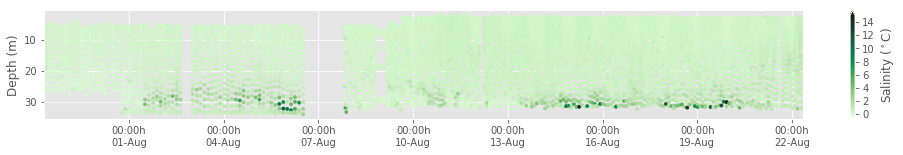

In [27]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['depth'], s=15, c=df['Chlorophyll'], marker='o', edgecolor='none', vmin=0, vmax=15, cmap=cmocean.cm.algae)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%H:%Mh\n%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Salinity ($^\circ$C)')
ax.set_ylabel('Depth (m)');

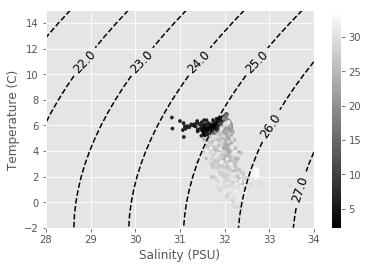

In [28]:
import seawater as sw

def plot_salvtemp(salt, temp, press, srange=[28,34], trange=[-2,15], ptitle=""): 
    plt.style.use('ggplot')
    
    # Figure out boudaries (mins and maxs)
    smin = srange[0]
    smax = srange[1]
    tmin = trange[0]
    tmax = trange[1]

    # Calculate how many gridcells we need in the x and y dimensions
    xdim = int(round((smax-smin)/0.1+1,0))
    ydim = int(round((tmax-tmin)+1,0))
    
    #print 'ydim: ' + str(ydim) + ' xdim: ' + str(xdim) + ' \n'
    if (xdim > 10000) or (ydim > 10000): 
        print('To many dimensions for grid in {cruise} {cast} file. Likely  missing data \n'.format(cruise=cruise,cast=cast))
        return
 
    # Create empty grid of zeros
    dens = np.zeros((ydim,xdim))
 
    # Create temp and salt vectors of appropiate dimensions
    ti = np.linspace(0,ydim-1,ydim)+tmin
    si = np.linspace(0,xdim-1,xdim)*0.1+smin
 
    # Loop to fill in grid with densities
    for j in range(0,int(ydim)):
        for i in range(0, int(xdim)):
            dens[j,i]=sw.dens0(si[i],ti[j])
 
    # Substract 1000 to convert to sigma-t
    dens = dens - 1000
 
    # Plot data ***********************************************
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    CS = plt.contour(si,ti,dens, linestyles='dashed', colors='k')
    plt.clabel(CS, fontsize=12, inline=1, fmt='%1.1f') # Label every second level
 
    ts = ax1.scatter(salt,temp, c=press, cmap='gray', s=10)
    plt.colorbar(ts )
    plt.ylim(tmin,tmax)
    plt.xlim(smin,smax)
 
    ax1.set_xlabel('Salinity (PSU)')
    ax1.set_ylabel('Temperature (C)')

    
    t = fig.suptitle(ptitle, fontsize=12, fontweight='bold')
    t.set_y(1.08)
    return fig  

fig = plot_salvtemp(df['Salinity'],df['Temperature'],df['depth'])